# Modelo: ***VGG16***

Modelo_2 utilizaremos una red neuronal pre-entrenada de *Keras* por medio de **Transfer Learning**

Red Neuronal utilizada: [***VGG16***](https://keras.io/api/applications/vgg/#vgg19-function)


Requisitos para poder aplicar el Modelo: *The default input size for this model is 224x224.*


In [1]:
import os, sys
sys.path.insert(1, '/content/drive/MyDrive/Colab Notebooks/MAIZ/src/utils') # 1 significa que se añade como la segunda prioridad (la posición 0 es normalmente el directorio actual del script).
                                                                            # Esto asegura que esta carpeta se revisará antes que otras rutas estándar.

In [2]:
# Nos posicionamos en el directorio de trabajo:
os.chdir("/content/drive/MyDrive/Colab Notebooks/MAIZ/src")

In [3]:
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks/MAIZ/src


In [4]:
## Librerias
# Data Analysis
import os, sys
sys.path.insert(0, "/content/drive/MyDrive/Colab Notebooks/MAIZ/src/utils")
from collections import Counter
import numpy as np
import pandas as pd
import pickle
from sklearn.utils import shuffle

# Data Preproccesing
from collections import Counter
import pickle
from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight
from funciones import (cargar_dataset, guardar_dataset,
                       transformacion_datos_X, transformacion_datos_y_OneHotEncoding,transformacion_datos_y_LabelEncoding,
                       dimensiones_imagenes, distribución_x_clase,
                       classification_report, plot_confusion_matrix, plot_ROC_Curve)

# Data Visualization
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
import cv2
import seaborn as sns

# Deep Learning (TensorFlow y tf.keras)
import tensorflow as tf
import tensorflow_hub as hub
from skimage.transform import resize
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, Dense, Conv2D, Flatten, Dropout,
                                     MaxPooling2D, GlobalAveragePooling2D,
                                     AveragePooling2D, BatchNormalization)
from tensorflow.keras.layers import RandomFlip, RandomRotation
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.models import save_model

# Métricas
from sklearn.metrics import (confusion_matrix, classification_report, precision_recall_curve,
                            precision_score, recall_score,
                            f1_score, accuracy_score, roc_curve, auc)

In [5]:
# Rutas de cada dataset: train-test-val:
train_path = "/content/drive/MyDrive/Colab Notebooks/MAIZ/src/data/data_splitted/train"
test_path = "/content/drive/MyDrive/Colab Notebooks/MAIZ/src/data/data_splitted/test"
val_path = "/content/drive/MyDrive/Colab Notebooks/MAIZ/src/data/data_splitted/val"

## **1. Procesamiento de los Datos**


In [6]:
# Lista con las clases:
clases = os.listdir("/content/drive/MyDrive/Colab Notebooks/MAIZ/src/data/data_splitted/train")
clases

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [7]:
# Diccionarios de Mapeos para las etiquetas:
# para train (a numericas):
clases_a_cat = {0:'Blight',
                        1:'Common_Rust',
                        2:'Gray_Leaf_Spot',
                        3:'Healthy'}

# y para los resultados/predicciones (a categóricas):
clases_a_num = {'Blight':0,
                'Common_Rust':1,
                'Gray_Leaf_Spot':2,
                'Healthy':3}

### Definimos las variables ***X***, ***y***

In [8]:
def creacion_listas_X_y(folder_path):
  X = []
  y = []
  #Lista con los nombres de cada clase:
  clases = os.listdir("/content/drive/MyDrive/Colab Notebooks/MAIZ/src/data/data_splitted/train")
  # Definimos las dimensiones de las imágenes
  img_width, img_height = 224, 224 # image_size

  # Iteramos en clases
  for class_name in clases: # lista nombres clases
    # Lista de las imagenes
    images_names = os.listdir(folder_path +'/'+ class_name)
    # Iteramos en las imagenes
    for img_name in images_names:
      image_path = folder_path +'/'+ class_name +'/'+ img_name # ruta de la imagen
      image_array = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) # pasamos la imagen a array con la imagen a color
      image = cv2.resize(image_array, (img_width, img_height)) # data preprocessing
      image = np.array(image) # usamos numpy para tener la imagen en array
      image = image.astype('float32') # pasamos la imagen a tipo 'float32'
      X.append(image) # agregamos la imagen a X
      y.append(class_name) # agregamos su nombre/target a y

  return X, y # retornamos una tupla con los valores (X, y)

In [9]:
# Creamos X, y:
X_train, y_train = creacion_listas_X_y(train_path)
X_test, y_test = creacion_listas_X_y(test_path)
X_val, y_val = creacion_listas_X_y(val_path)

### ***X***

In [10]:
# Procesamos X_train, X_test, X_val:
X_train, X_test, X_val = transformacion_datos_X(X_train, X_test, X_val)

In [11]:
# Visualizamos las dimensiones en train
X_train_shapes = dimensiones_imagenes(X_train)
print("X_train:  {} tipos de dimensiones".format(len(X_train_shapes)))

(224, 224, 3) --> 3348 imagenes
X_train:  1 tipos de dimensiones


### ***y*** : Target

Aplicamos la transformacion de la target a vectores binarios one-hot.

In [12]:
# Procesamos y_train, y_test, y_val:
y_train, y_test, y_val = transformacion_datos_y_OneHotEncoding(y_train, y_test, y_val)

Visualizamos el shape de y_train e y_test:

In [13]:
# Visualizamos las dimensiones
print("y_train: {}".format(y_train.shape))
print("y_test: {}".format(y_test.shape))
print("y_val: {}".format(y_val.shape))

y_train: (3348, 4)
y_test: (423, 4)
y_val: (417, 4)


Como las imagenes están cargadas de forma ordenada vamos a mezclarlas aleatoriamente con el Metodo `shuffle`

In [14]:
# Utilizamos una semilla aleatoria fija (random seed).
# Esto garantiza que la secuencia de desordenamiento sea siempre la misma en cada ejecución.
seed = 23
X_train, y_train = shuffle(X_train, y_train, random_state=seed)
X_test, y_test = shuffle(X_test, y_test, random_state=seed)
X_val, y_val = shuffle(X_val, y_val, random_state=seed)

##### ***Definimos los class_weights***

Utilizaremos la función `compute_class_weights` para calcular automáticamente los pesos asociados a las clases de un conjunto de datos desequilibrado. Estos pesos se pueden usar en modelos de machine learning para contrarrestar el sesgo hacia las clases más frecuentes, garantizando que las clases menos representadas tengan una mayor influencia durante el entrenamiento.

La fórmula utilizada es la siguiente:
#### $w_j= \frac{N}{k.n_j}$  

* $w_j$: es el peso de la clase $j$.
* $N$: n° total de imagenes.
* $k$: n° total de clases.
* $n_j$: n° de imagenes de la clase $j$.



Calculamos manualmente los pesos aplicando la fórmula:

In [15]:
train_path = "/content/drive/MyDrive/Colab Notebooks/MAIZ/src/data/data_splitted/train"
df_train = distribución_x_clase(train_path)

# Pesos originales
df_train['original_weights'] = df_train['N° of Images'] / df_train['N° of Images'].sum()

# Pesos definidos
df_train['new_weights'] = df_train['N° of Images'].sum()/(len(clases)*df_train['N° of Images'])
df_train

,Class_Name,N° of Images,original_weights,new_weights
0,Blight,916,0.273596,0.913755
1,Common_Rust,1044,0.311828,0.801724
2,Gray_Leaf_Spot,459,0.137097,1.823529
3,Healthy,929,0.277479,0.900969


In [16]:
# Creamos un diccionario con los pesos para cada clase:
class_weights = {i : df_train['new_weights'][i] for i in range(len(df_train))}
class_weights

{0: 0.9137554585152838,
 1: 0.8017241379310345,
 2: 1.8235294117647058,
 3: 0.9009687836383208}

***
# **Modelos** ***VGG16***

## **Version 2.1**


### **1. Modelo**

In [19]:
model = Sequential()

base_model = tf.keras.applications.VGG16(
    input_shape=(224, 224, 3),
    include_top=False, # No incluimos las 'fully-connected layers'
    weights="imagenet",
    classifier_activation="softmax"
)

for layer in base_model.layers:
  layer.trainable=False  # No queremos que este modelo se reentrene, pues se perdería todo el aprendizaje que trae)

model.add(base_model)
model.add(GlobalAveragePooling2D())  # Reduce (7, 7, C) -> (C)
model.add(Dropout(0.2))
model.add(Dense(len(clases), activation='softmax'))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,716,740 (56.14 MB)

 Trainable params: 2,052 (8.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [21]:
# Compilamos: definimos loss and optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### **2. Entrenamiento del Modelo**

In [22]:
# Indicamos el Early-Stopping: patience indica que cuando se repite n veces que frene
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)
n_epochs = 15

model_hist = model.fit(X_train, y_train,
                        validation_data= (X_test, y_test),
                        batch_size= 128,
                        epochs= n_epochs,
                        callbacks= callback)


Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.3034 - loss: 1.3901 - val_accuracy: 0.5437 - val_loss: 1.1431
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 600ms/step - accuracy: 0.5732 - loss: 1.1220 - val_accuracy: 0.7352 - val_loss: 0.9985
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 591ms/step - accuracy: 0.6904 - loss: 0.9810 - val_accuracy: 0.7660 - val_loss: 0.8978
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 610ms/step - accuracy: 0.7318 - loss: 0.8759 - val_accuracy: 0.7754 - val_loss: 0.8207
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 589ms/step - accuracy: 0.7605 - loss: 0.8027 - val_accuracy: 0.7707 - val_loss: 0.7620
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 621ms/step - accuracy: 0.7644 - loss: 0.7438 - val_accuracy: 0.7778 - val_loss: 0.7159
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.7751 - loss: 0.7033 - val_accuracy: 0.7825 - val_loss: 0.6782
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 589ms/step - accuracy: 0.7898 - loss: 0.6680 - val_accurac

### **3. Evaluación del Modelo**

#### **Accuracy - Loss**

In [23]:
# Tupla con los valores: (val_loss, val_accuracy):
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest loss:', round(test_loss,4))
print('Test accuracy:', round(test_acc,4))

14/14 - 19s - 1s/step - accuracy: 0.8132 - loss: 0.5198

Test loss: 0.5198
Test accuracy: 0.8132


#### **Predicciones**

In [24]:
y_pred = np.argmax(model.predict(X_test), axis=1) # model.predict(X_test): obtenemos las probabilidades de cada clase en cada imagen.
                                                  # axis=1 para encontrar el índice del valor/probabilidad máxima en cada fila del array

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step


In [25]:
# Convertimos y_test de one-hot(binario) a label-encoder(multiclase)
y_test = np.argmax(y_test, axis=1).reshape(-1,1) # (shape: (423,))

In [26]:
# Para cambiar la dimension, que sea igual a la predicha:
y_test = y_test.reshape(len(y_test)) # otra forma: y_test.shape = y_pred.shape

In [27]:
y_pred

array([0, 0, 0, 3, 0, 3, 1, 0, 0, 0, 3, 3, 3, 1, 2, 1, 3, 2, 0, 0, 3, 3,
       3, 0, 1, 0, 0, 0, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 0, 0, 1, 3, 0, 3,
       1, 1, 1, 3, 3, 1, 3, 3, 0, 1, 3, 0, 1, 1, 0, 3, 0, 0, 1, 1, 1, 0,
       3, 1, 1, 3, 1, 0, 0, 3, 0, 1, 1, 3, 0, 0, 0, 1, 1, 1, 3, 1, 1, 3,
       0, 0, 0, 0, 0, 3, 1, 0, 0, 3, 3, 2, 0, 3, 3, 1, 1, 0, 1, 1, 3, 1,
       2, 3, 0, 0, 1, 1, 0, 1, 3, 0, 0, 3, 0, 3, 1, 1, 0, 1, 2, 0, 3, 3,
       3, 1, 0, 1, 1, 0, 0, 3, 3, 0, 0, 1, 3, 0, 3, 3, 1, 3, 3, 3, 1, 1,
       3, 1, 1, 2, 1, 1, 1, 3, 0, 1, 3, 0, 0, 1, 3, 3, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 3, 3, 0, 2, 1, 0, 0, 3, 0, 1, 2, 1, 0, 3, 3, 1, 2, 1,
       1, 1, 1, 1, 3, 0, 0, 3, 3, 0, 0, 3, 0, 1, 1, 0, 1, 0, 0, 3, 0, 0,
       2, 3, 0, 1, 0, 1, 1, 0, 1, 0, 1, 3, 3, 1, 0, 3, 3, 1, 3, 0, 3, 0,
       0, 1, 1, 0, 1, 2, 0, 3, 3, 0, 1, 1, 1, 3, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 3, 3, 1, 0, 1, 1, 1, 1, 3, 3, 2, 1, 1, 1, 3, 1, 0, 1, 3, 3, 3,
       0, 0, 3, 1, 0, 0, 3, 1, 0, 0, 1, 0, 0, 0, 1,

#### **Classification Report**

In [28]:
# Primero debemos mapear y_pred e y_test a variables categoricas:
y_pred = [clases_a_cat[prediccion] for prediccion in y_pred] # Transformamos las predicciones de las imagenes en formato categorico (nombres de las clases)
y_test = [clases_a_cat[y_num] for y_num in y_test] # Transformamos de numerico a categorica los valores de y_test

In [29]:
informe = classification_report(y_test, y_pred)
print(informe)

                precision    recall  f1-score   support

        Blight       0.66      0.85      0.74       116
   Common_Rust       0.92      0.92      0.92       132
Gray_Leaf_Spot       0.75      0.21      0.32        58
       Healthy       0.90      0.96      0.93       117

      accuracy                           0.81       423
     macro avg       0.81      0.73      0.73       423
  weighted avg       0.82      0.81      0.79       423



In [30]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))

Accuracy: 0.81
Precision: 0.82
Recall: 0.81


#### **Gráfico Train y Test Accuracy y Loss**

In [31]:
print(type(model_hist))

<class 'keras.src.callbacks.history.History'>


In [35]:
# Creamos un df con el history del modelo:
# Diccionario con los valores: las keys son loss - sparse_categorical_accuracy - val_loss - val_sparse_categorical_accuracy
model_hist.history

# Para ver las keys
model_hist.history.keys()

# Creamos un df con la info
df_history = pd.DataFrame(model_hist.history)
df_history

,accuracy,loss,val_accuracy,val_loss
0,0.392772,1.295667,0.543735,1.143097
1,0.612605,1.086033,0.735225,0.998488
2,0.704002,0.949768,0.765957,0.897777
3,0.731780,0.860672,0.775414,0.820714
4,0.755974,0.793105,0.770686,0.761953
5,0.769415,0.736953,0.777778,0.715884
6,0.777479,0.694000,0.782506,0.678151
7,0.790323,0.658979,0.794326,0.646695
8,0.804361,0.626579,0.789598,0.620126
9,0.797790,0.612038,0.806147,0.597850


Text(0.5, 1.0, 'Training and Validation - Accuracy')

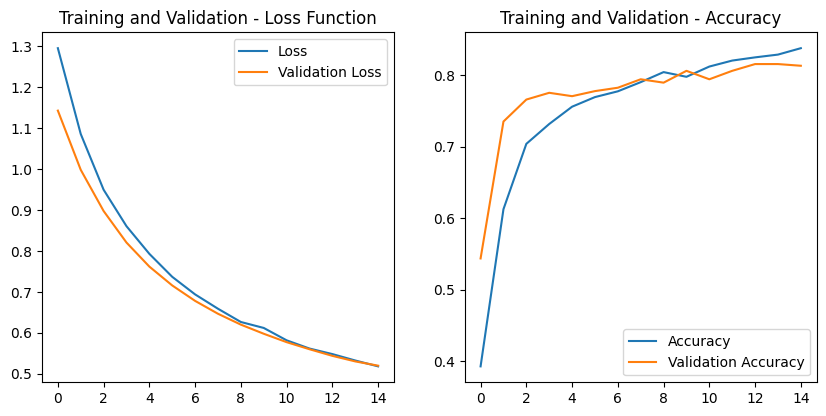

In [37]:
# Graficos Train-Test Accuracy y Loss
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(model_hist.history['loss'], label='Loss')
plt.plot(model_hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(model_hist.history['accuracy'], label='Accuracy')
plt.plot(model_hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation - Accuracy')

#### **Matriz de Confusión**<br>

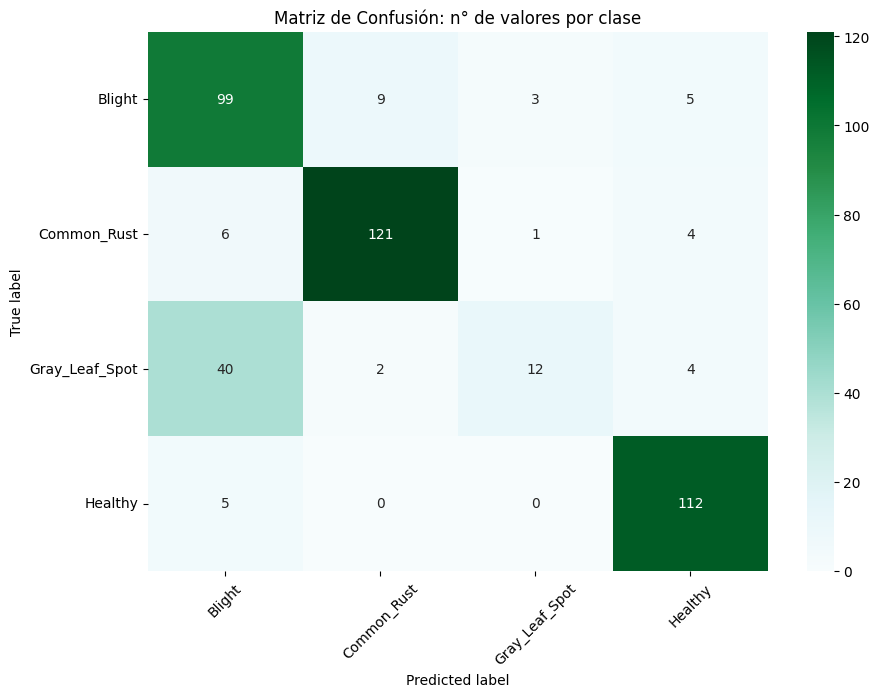

In [38]:
# Generar la matriz de confusión
plot_confusion_matrix(y_test, y_pred,title='Matriz de Confusión: n° de valores por clase')

In [39]:
# valores de la diagonal principal:
diagonal_sum = np.trace(confusion_matrix(y_test, y_pred))
print("Predicciones correctas: {}".format(diagonal_sum)) # suma de valores de la diagonal principal
print("Predicciones erroneas: {}".format(len(y_pred)-diagonal_sum)) # suma de valores fuera de la diagonal principaldiagonal_sum

Predicciones correctas: 344
Predicciones erroneas: 79


In [40]:
# Crearemos una Matriz de Confusion con los % predichos para cada clase:
cm = confusion_matrix(y_test, y_pred) # creamos la Matriz de Confusion

# Calculamos los % de cada clase
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Redondear los valores a 1 decimal
cm_percent_rounded = np.round(cm_percent, 1)

# Convertir los valores redondeados a cadenas de caracteres
cm_percent_str = np.char.mod('%.1f', cm_percent_rounded)

# Agregamos el simbolo % a cada valor:
cm_porcentajes = np.char.add(cm_percent_str, '%')
cm_porcentajes

array([['85.3%', '7.8%', '2.6%', '4.3%'],
       ['4.5%', '91.7%', '0.8%', '3.0%'],
       ['69.0%', '3.4%', '20.7%', '6.9%'],
       ['4.3%', '0.0%', '0.0%', '95.7%']], dtype='<U5')

#### **ROC Curve**

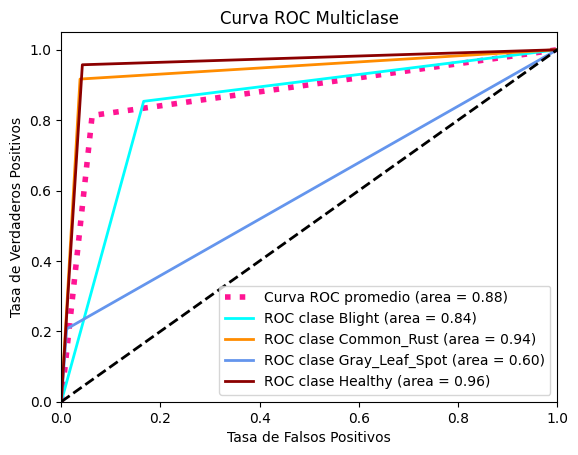

In [41]:
plot_ROC_Curve(y_pred, y_test)

***
## **Version 2.2**

Tecnicas aplicadas:
* *Data Augmentation*

### **1. Modelo**

In [15]:
base_model = tf.keras.applications.VGG16(
    input_shape=(224, 224, 3),
    include_top=False, # No incluimos las 'fully-connected layers'
    weights="imagenet",
    classifier_activation="softmax")


base_model.trainable = False # No queremos que este modelo se reentrene, pues se perdería todo el aprendizaje que trae)

inputs = keras.Input(shape=(224, 224, 3))

data_augmentation = Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])
x = data_augmentation(inputs)

x = base_model(x, training=False) # para que el base-model no se re-entrene
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, kernel_initializer='he_normal')(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(4,activation='softmax')(x) # definimos una fully-connected layer
model = keras.Model(inputs, outputs)

In [54]:
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_5 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 7, 7, 128)           │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 7, 7, 4)             │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,781,380 (56.39 MB)

 Trainable params: 66,436 (259.52 KB)

 Non-trainable params: 14,714,944 (56.13 MB)

In [16]:
# define loss and optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### **2. Entrenamiento del Modelo**

In [18]:
# Indicamos el Early-Stopping: patience indica que cuando se repite n veces que frene
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)
n_epochs = 15

model_hist = model.fit(X_train, y_train,
                        validation_data= (X_test, y_test),
                        batch_size= 128,
                        epochs= n_epochs,
                        callbacks= callback
                        )

Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 45s 955ms/step - accuracy: 0.7432 - loss: 0.8039 - val_accuracy: 0.3830 - val_loss: 4.2069
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 672ms/step - accuracy: 0.8809 - loss: 0.3414 - val_accuracy: 0.4350 - val_loss: 2.3670
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 688ms/step - accuracy: 0.8915 - loss: 0.2878 - val_accuracy: 0.5248 - val_loss: 1.8688
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 718ms/step - accuracy: 0.9060 - loss: 0.2559 - val_accuracy: 0.5957 - val_loss: 1.3861
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 737ms/step - accuracy: 0.8991 - loss: 0.2598 - val_accuracy: 0.8322 - val_loss: 0.5467
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 726ms/step - accuracy: 0.9183 - loss: 0.2419 - val_accuracy: 0.6785 - val_loss: 0.9908
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 700ms/step - accuracy: 0.9166 - loss: 0.2386 - val_accuracy: 0.8203 - val_loss: 0.5006
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 695ms/step - accuracy: 0.9379 - loss: 0.1863 - val_accu

### **3. Evaluacion del Modelo**

#### **Accuracy - Loss**

In [19]:
# Tupla con los valores: (val_loss, val_accuracy):
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest loss:', round(test_loss,4))
print('Test accuracy:', round(test_acc,4))

14/14 - 7s - 490ms/step - accuracy: 0.8913 - loss: 0.3165

Test loss: 0.3165
Test accuracy: 0.8913


#### **Predicciones**

In [20]:
y_pred = np.argmax(model.predict(X_test), axis=1) # model.predict(X_test): obtenemos las probabilidades de cada clase en cada imagen.
                                                  # axis=1 para encontrar el índice del valor/probabilidad máxima en cada fila del array

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step


In [21]:
# Convertimos y_test de one-hot(binario) a label-encoder(multiclase)
y_test = np.argmax(y_test, axis=1).reshape(-1,1) # (shape: (423,))

In [22]:
# Para cambiar la dimension, que sea igual a la predicha:
y_test = y_test.reshape(len(y_test)) # otra forma: y_test.shape = y_pred.shape

In [23]:
y_pred

array([0, 0, 2, 3, 2, 3, 1, 0, 0, 2, 3, 3, 3, 1, 2, 0, 3, 2, 0, 0, 3, 3,
       3, 0, 1, 0, 0, 0, 0, 3, 1, 1, 1, 3, 3, 3, 3, 3, 2, 0, 1, 3, 0, 3,
       1, 1, 1, 2, 3, 1, 3, 3, 0, 1, 3, 2, 1, 1, 2, 3, 2, 0, 0, 0, 1, 0,
       3, 1, 1, 3, 1, 0, 0, 3, 2, 1, 1, 3, 0, 1, 2, 1, 1, 1, 3, 1, 1, 1,
       2, 0, 0, 0, 0, 3, 1, 0, 0, 3, 3, 2, 2, 3, 3, 1, 1, 0, 1, 1, 3, 1,
       2, 3, 0, 0, 1, 1, 0, 1, 3, 0, 0, 3, 0, 1, 0, 1, 0, 1, 2, 0, 3, 3,
       3, 1, 2, 1, 1, 2, 0, 3, 3, 0, 0, 2, 0, 0, 3, 3, 1, 3, 3, 3, 1, 1,
       3, 1, 1, 2, 1, 1, 1, 3, 0, 1, 3, 2, 2, 1, 3, 3, 0, 2, 1, 1, 2, 1,
       0, 0, 2, 1, 3, 3, 0, 2, 1, 0, 0, 3, 0, 1, 2, 1, 0, 3, 3, 1, 2, 1,
       1, 1, 1, 1, 3, 2, 0, 0, 3, 2, 2, 3, 2, 1, 1, 0, 1, 0, 0, 3, 3, 0,
       2, 3, 0, 1, 0, 1, 1, 0, 1, 0, 1, 3, 0, 1, 2, 3, 2, 1, 3, 2, 2, 0,
       2, 1, 1, 0, 1, 2, 0, 3, 3, 0, 1, 1, 1, 3, 0, 0, 0, 1, 1, 1, 1, 2,
       1, 3, 3, 0, 3, 1, 1, 0, 1, 2, 3, 2, 1, 1, 1, 3, 1, 0, 0, 3, 3, 3,
       2, 2, 3, 1, 0, 0, 3, 1, 0, 2, 1, 0, 2, 2, 2,

#### **Classification Report**

In [24]:
# Primero debemos mapear y_pred e y_test a variables categoricas:
y_pred = [clases_a_cat[prediccion] for prediccion in y_pred] # Transformamos las predicciones de las imagenes en formato categorico (nombres de las clases)
y_test = [clases_a_cat[y_num] for y_num in y_test] # Transformamos de numerico a categorica los valores de y_test

In [25]:
informe = classification_report(y_test, y_pred)
print(informe)

                precision    recall  f1-score   support

        Blight       0.83      0.85      0.84       116
   Common_Rust       0.98      0.94      0.96       132
Gray_Leaf_Spot       0.66      0.78      0.71        58
       Healthy       1.00      0.93      0.96       117

      accuracy                           0.89       423
     macro avg       0.87      0.88      0.87       423
  weighted avg       0.90      0.89      0.89       423



In [26]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))

Accuracy: 0.89
Precision: 0.90
Recall: 0.89


#### **Gráfico Train y Test Accuracy y Loss**

In [ ]:
print(type(model_hist))

In [28]:
# Creamos un df con el history del modelo:
# Diccionario con los valores: las keys son loss - sparse_categorical_accuracy - val_loss - val_sparse_categorical_accuracy
model_hist.history

# Para ver las keys
model_hist.history.keys()

# Creamos un df con la info
df_history = pd.DataFrame(model_hist.history)
df_history

,accuracy,loss,val_accuracy,val_loss
0,0.823178,0.561371,0.382979,4.206932
1,0.880824,0.344763,0.434988,2.367043
2,0.896057,0.280647,0.524823,1.868798
3,0.899642,0.268142,0.595745,1.386093
4,0.904122,0.252061,0.832151,0.546733
5,0.915173,0.236203,0.678487,0.990766
6,0.916965,0.230574,0.820331,0.500551
7,0.931601,0.195903,0.891253,0.316475
8,0.925030,0.209791,0.884161,0.335201
9,0.926523,0.208237,0.884161,0.328154


Text(0.5, 1.0, 'Training and Validation - Accuracy')

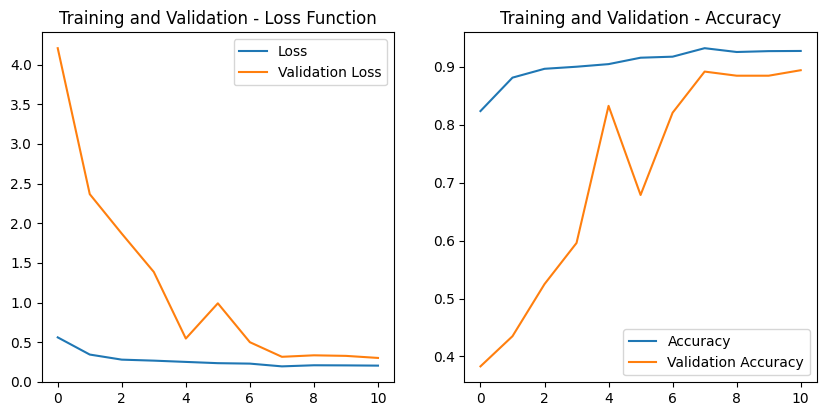

In [29]:
# Graficos Train-Test Accuracy y Loss
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(model_hist.history['loss'], label='Loss')
plt.plot(model_hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(model_hist.history['accuracy'], label='Accuracy')
plt.plot(model_hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation - Accuracy')

#### **Matriz de Confusión**<br>

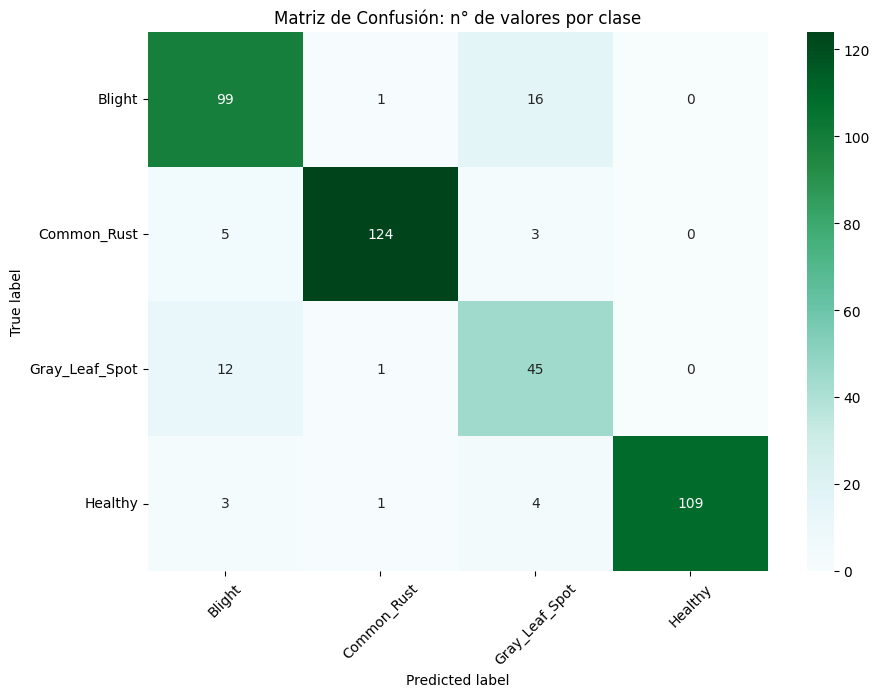

In [30]:
# Generar la matriz de confusión
plot_confusion_matrix(y_test, y_pred,title='Matriz de Confusión: n° de valores por clase')

In [31]:
# valores de la diagonal principal:
diagonal_sum = np.trace(confusion_matrix(y_test, y_pred))
print("Predicciones correctas: {}".format(diagonal_sum)) # suma de valores de la diagonal principal
print("Predicciones erroneas: {}".format(len(y_pred)-diagonal_sum)) # suma de valores fuera de la diagonal principaldiagonal_sum

Predicciones correctas: 377
Predicciones erroneas: 46


In [32]:
# Crearemos una Matriz de Confusion con los % predichos para cada clase:
cm = confusion_matrix(y_test, y_pred) # creamos la Matriz de Confusion

# Calculamos los % de cada clase
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Redondear los valores a 1 decimal
cm_percent_rounded = np.round(cm_percent, 1)

# Convertir los valores redondeados a cadenas de caracteres
cm_percent_str = np.char.mod('%.1f', cm_percent_rounded)

# Agregamos el simbolo % a cada valor:
cm_porcentajes = np.char.add(cm_percent_str, '%')
cm_porcentajes

array([['85.3%', '0.9%', '13.8%', '0.0%'],
       ['3.8%', '93.9%', '2.3%', '0.0%'],
       ['20.7%', '1.7%', '77.6%', '0.0%'],
       ['2.6%', '0.9%', '3.4%', '93.2%']], dtype='<U5')

#### **ROC Curve**

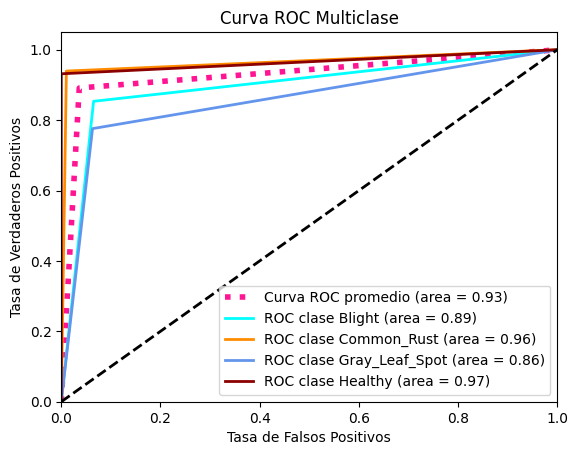

In [33]:
plot_ROC_Curve(y_pred, y_test)

***
## **Version 2.3**
Tecnicas aplicadas:
* *Data Augmentation*
* *Class Weights*

### **1. Modelo**

In [17]:
base_model = tf.keras.applications.VGG16(
    input_shape=(224, 224, 3),
    include_top=False, # No incluimos las 'fully-connected layers'
    weights="imagenet",
    classifier_activation="softmax")


base_model.trainable = False # No queremos que este modelo se reentrene, pues se perdería todo el aprendizaje que trae)

inputs = keras.Input(shape=(224, 224, 3))

data_augmentation = Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])
x = data_augmentation(inputs)

x = base_model(x, training=False) # para que el base-model no se re-entrene
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, kernel_initializer='he_normal')(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(4,activation='softmax')(x) # definimos una fully-connected layer
model = keras.Model(inputs, outputs)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,564,356 (105.15 MB)

 Trainable params: 12,848,644 (49.01 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [19]:
# Compilamos: definimos loss and optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### **2. Entrenamiento del Modelo**

In [20]:
# Indicamos el Early-Stopping: patience indica que cuando se repite n veces que frene
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)
n_epochs = 15

model_hist = model.fit(X_train, y_train,
                        validation_data= (X_test, y_test),
                        batch_size= 128,
                        epochs= n_epochs,
                        callbacks= callback,
                        class_weight = class_weights)


Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 946ms/step - accuracy: 0.7440 - loss: 0.8837 - val_accuracy: 0.4704 - val_loss: 3.3855
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 678ms/step - accuracy: 0.8625 - loss: 0.3976 - val_accuracy: 0.4870 - val_loss: 2.3022
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 719ms/step - accuracy: 0.8885 - loss: 0.3392 - val_accuracy: 0.5556 - val_loss: 1.7401
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 722ms/step - accuracy: 0.8958 - loss: 0.2849 - val_accuracy: 0.7707 - val_loss: 0.8243
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 755ms/step - accuracy: 0.8946 - loss: 0.3219 - val_accuracy: 0.8298 - val_loss: 0.5919
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 761ms/step - accuracy: 0.9075 - loss: 0.2828 - val_accuracy: 0.8582 - val_loss: 0.5341
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 725ms/step - accuracy: 0.9220 - loss: 0.2523 - val_accuracy: 0.8936 - val_loss: 0.3464
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 767ms/step - accuracy: 0.9218 - loss: 0.2510 - val_accu

### **3. Evaluación del Modelo**

#### **Accuracy - Loss**

In [21]:
# Tupla con los valores: (val_loss, val_accuracy):
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest loss:', round(test_loss,4))
print('Test accuracy:', round(test_acc,4))

14/14 - 7s - 513ms/step - accuracy: 0.8440 - loss: 0.4565

Test loss: 0.4565
Test accuracy: 0.844


#### **Predicciones**

In [22]:
y_pred = np.argmax(model.predict(X_test), axis=1) # model.predict(X_test): obtenemos las probabilidades de cada clase en cada imagen.
                                                  # axis=1 para encontrar el índice del valor/probabilidad máxima en cada fila del array

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step


In [23]:
# Convertimos y_test de one-hot(binario) a label-encoder(multiclase)
y_test = np.argmax(y_test, axis=1).reshape(-1,1) # (shape: (423,))

In [24]:
# Para cambiar la dimension, que sea igual a la predicha:
y_test = y_test.reshape(len(y_test)) # otra forma: y_test.shape = y_pred.shape

In [25]:
y_pred

array([0, 0, 2, 3, 2, 3, 1, 0, 0, 2, 3, 3, 3, 1, 2, 0, 3, 2, 2, 2, 3, 2,
       3, 2, 1, 0, 0, 0, 0, 3, 1, 1, 1, 3, 3, 3, 3, 3, 2, 0, 1, 3, 0, 3,
       1, 1, 1, 2, 3, 1, 3, 3, 0, 1, 3, 2, 1, 1, 2, 3, 2, 0, 1, 0, 1, 2,
       3, 1, 1, 3, 1, 0, 0, 2, 2, 1, 1, 3, 0, 1, 2, 1, 1, 1, 3, 1, 1, 2,
       2, 0, 0, 0, 0, 3, 1, 0, 0, 3, 3, 2, 2, 3, 3, 1, 1, 0, 1, 1, 3, 1,
       2, 3, 0, 2, 1, 1, 2, 1, 3, 2, 0, 3, 0, 1, 1, 1, 0, 1, 2, 0, 3, 3,
       3, 1, 2, 1, 1, 2, 0, 3, 3, 0, 0, 2, 0, 0, 3, 3, 1, 3, 3, 3, 1, 1,
       3, 1, 1, 2, 1, 1, 1, 3, 2, 1, 3, 2, 2, 1, 3, 3, 2, 2, 1, 1, 2, 1,
       0, 0, 2, 1, 3, 3, 0, 2, 1, 0, 0, 3, 2, 1, 2, 1, 2, 3, 3, 1, 2, 1,
       1, 1, 1, 1, 3, 2, 2, 0, 3, 2, 2, 3, 2, 1, 1, 0, 1, 2, 0, 3, 3, 0,
       2, 3, 0, 1, 0, 1, 1, 0, 1, 2, 1, 3, 0, 1, 2, 3, 2, 1, 3, 2, 2, 2,
       2, 1, 1, 2, 1, 2, 2, 3, 2, 0, 1, 1, 1, 3, 2, 2, 0, 1, 1, 1, 1, 2,
       1, 3, 3, 2, 3, 1, 1, 1, 1, 2, 3, 2, 1, 1, 1, 3, 1, 0, 0, 3, 3, 3,
       2, 2, 3, 1, 0, 0, 3, 1, 0, 2, 1, 2, 2, 2, 2,

#### **Classification Report**

In [26]:
# Primero debemos mapear y_pred e y_test a variables categoricas:
y_pred = [clases_a_cat[prediccion] for prediccion in y_pred] # Transformamos las predicciones de las imagenes en formato categorico (nombres de las clases)
y_test = [clases_a_cat[y_num] for y_num in y_test] # Transformamos de numerico a categorica los valores de y_test

In [27]:
informe = classification_report(y_test, y_pred)
print(informe)

                precision    recall  f1-score   support

        Blight       0.91      0.63      0.74       116
   Common_Rust       0.97      0.93      0.95       132
Gray_Leaf_Spot       0.49      0.91      0.64        58
       Healthy       1.00      0.92      0.96       117

      accuracy                           0.84       423
     macro avg       0.84      0.85      0.82       423
  weighted avg       0.90      0.84      0.85       423



In [28]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))

Accuracy: 0.84
Precision: 0.90
Recall: 0.84


#### **Gráfico Train y Test Accuracy y Loss**

In [29]:
print(type(model_hist))

<class 'keras.src.callbacks.history.History'>


In [30]:
# Creamos un df con el history del modelo:
# Diccionario con los valores: las keys son loss - sparse_categorical_accuracy - val_loss - val_sparse_categorical_accuracy
model_hist.history

# Para ver las keys
model_hist.history.keys()

# Creamos un df con la info
df_history = pd.DataFrame(model_hist.history)
df_history

,accuracy,loss,val_accuracy,val_loss
0,0.810335,0.696620,0.470449,3.385535
1,0.867682,0.399079,0.486998,2.302202
2,0.884707,0.350018,0.555556,1.740075
3,0.896057,0.307384,0.770686,0.824278
4,0.896953,0.308877,0.829787,0.591852
5,0.904719,0.274601,0.858156,0.534089
6,0.914277,0.265140,0.893617,0.346392
7,0.918160,0.255927,0.822695,0.507974
8,0.911888,0.256094,0.843972,0.452178
9,0.925329,0.231274,0.848700,0.390082


Text(0.5, 1.0, 'Training and Validation - Accuracy')

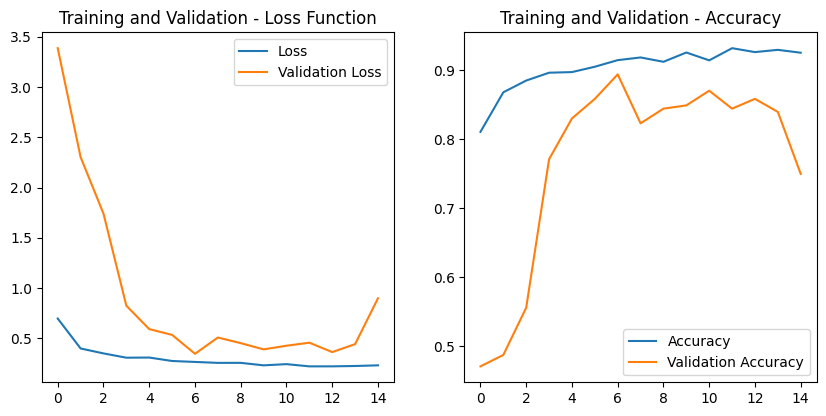

In [31]:
# Graficos Train-Test Accuracy y Loss
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(model_hist.history['loss'], label='Loss')
plt.plot(model_hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(model_hist.history['accuracy'], label='Accuracy')
plt.plot(model_hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation - Accuracy')

#### **Matriz de Confusión**<br>

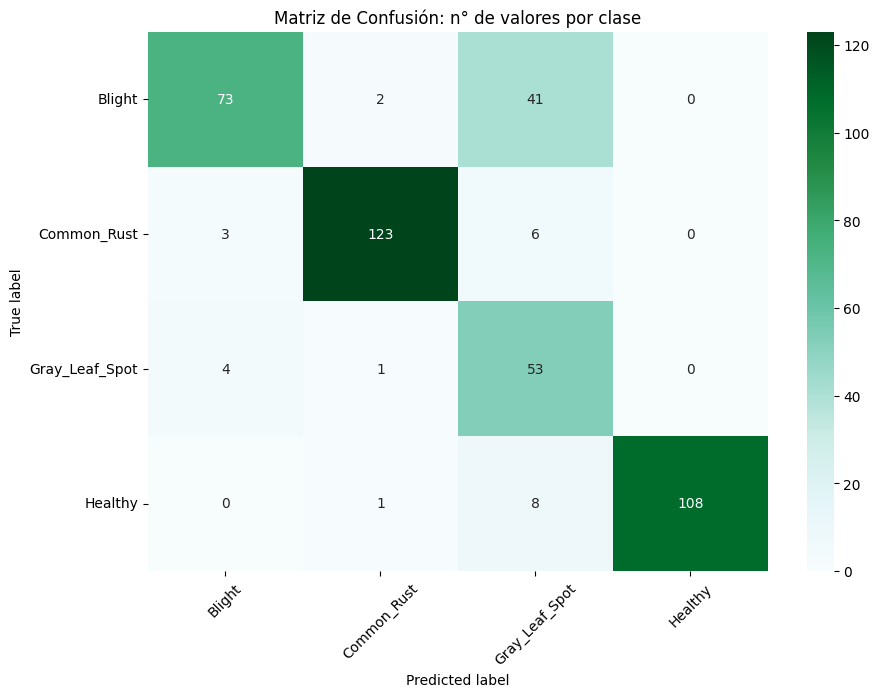

In [32]:
# Generar la matriz de confusión
plot_confusion_matrix(y_test, y_pred,title='Matriz de Confusión: n° de valores por clase')

In [33]:
# valores de la diagonal principal:
diagonal_sum = np.trace(confusion_matrix(y_test, y_pred))
print("Predicciones correctas: {}".format(diagonal_sum)) # suma de valores de la diagonal principal
print("Predicciones erroneas: {}".format(len(y_pred)-diagonal_sum)) # suma de valores fuera de la diagonal principaldiagonal_sum

Predicciones correctas: 357
Predicciones erroneas: 66


In [34]:
# Crearemos una Matriz de Confusion con los % predichos para cada clase:
cm = confusion_matrix(y_test, y_pred) # creamos la Matriz de Confusion

# Calculamos los % de cada clase
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Redondear los valores a 1 decimal
cm_percent_rounded = np.round(cm_percent, 1)

# Convertir los valores redondeados a cadenas de caracteres
cm_percent_str = np.char.mod('%.1f', cm_percent_rounded)

# Agregamos el simbolo % a cada valor:
cm_porcentajes = np.char.add(cm_percent_str, '%')
cm_porcentajes

array([['62.9%', '1.7%', '35.3%', '0.0%'],
       ['2.3%', '93.2%', '4.5%', '0.0%'],
       ['6.9%', '1.7%', '91.4%', '0.0%'],
       ['0.0%', '0.9%', '6.8%', '92.3%']], dtype='<U5')

#### **ROC Curve**

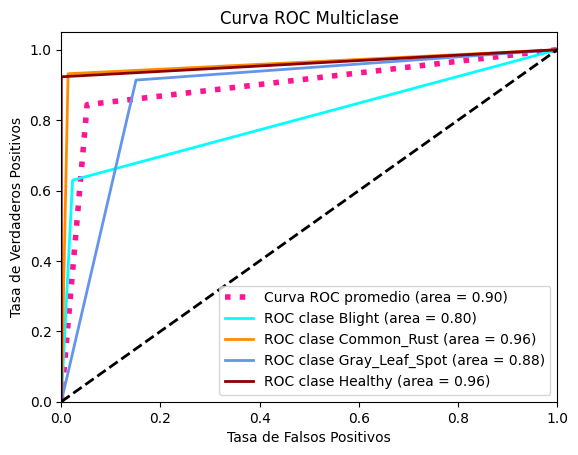

In [35]:
plot_ROC_Curve(y_pred, y_test)